In [33]:
import pandas as pd
import numpy as np
import arrow
from collections import defaultdict

#Boosting
import xgboost as xgb

### Defining functions for feature engineering

In [34]:
def factorizing(dataset):
    cat_feats = dataset.select_dtypes(include=[np.object]).columns
    factorized_dict = {}
    for cat_feat in cat_feats:
        factorized_dict[cat_feat] = pd.factorize(dataset[cat_feat])[1]
    return factorized_dict

def create_labels(dataset):
    cat_feats = dataset.select_dtypes(include=[np.object]).columns

    for cat_feat in cat_feats:
        dataset['{}_cat'.format(cat_feat)] = dataset[cat_feat].map(
            lambda x: factorized_dict[cat_feat].get_loc(x))

In [35]:
#Loading a file with all days from years 2006-2008 in format YYYYMMDD
all_days = pd.read_csv('../notebooks/all_days.csv')
#calculating how far is each day in years 2006-2008 from the nearest holiday
US_hol = ['20060101', '20060116', '20060220', '20060529', '20060704', '20060904', '20061009', 
          '20061111', '20061123', '20061225', '20070101', '20070115', '20070219', '20070528', 
          '20070704', '20070903', '20071008', '20071111', '20071122', '20071225', '20080101',
          '20080121', '20080218', '20080526', '20080704', '20080901', '20081013', '20081111', 
          '20081127', '20081225', '20090101']
dict_hol = {}
for day in all_days['All_days'].astype(str):
    days_to = -1000
    i=0
    while days_to < 0:    
        days_to = (arrow.get(US_hol[i], 'YYYYMMDD') - arrow.get(day, 'YYYYMMDD')).days
        i+=1
    dict_hol[day] = days_to

# mapping holiday dictionary to days
all_days['days_to_holiday'] = all_days['All_days'].astype(str).map(dict_hol)
# fake year dictionary to help with holidays
fake_year = {'0': '2006', '1': '2007', '2':'2008'}

def feat_eng(dataset, train_set=False):
    # for data calculations
    dataset['month_str'] = dataset['month'].astype(str)
    dataset['day_of_month_str'] = dataset['day_of_month'].astype(str)

    dataset['month_2g'] = dataset['month_str'].apply(lambda x: x if len(x)==2 else '0' + str(x))
    dataset['day_of_month_2g'] = dataset['day_of_month_str'].apply(lambda x: x if len(x)==2 else '0' + str(x))
    
    # assigning a fake year to 'year' for holiday calculations
    dataset['fake_year'] = dataset['year'].apply(lambda x: fake_year[str(x)])
    
    # combining year, month, day for arrow calculations
    dataset['full_date'] = dataset[['fake_year', 'month_2g', 'day_of_month_2g']].apply(lambda x: ''.join(x), axis=1)
    
    dataset['is_holiday'] = dataset['full_date'].apply(lambda x: True if x in US_hol else False)
    dataset['days_to_holiday'] = dataset['full_date'].map(dict_hol)
    
    dataset['is_tail_number10'] = dataset['tail_number']==10
    dataset['is_tail_numberNA'] = dataset['tail_number']==-1
    dataset['is_tail_number1679'] = dataset['tail_number']==1679
    
    if train_set:
        dataset['is_delayed_15'] = dataset['target_delay']>15

### Data preparation

In [36]:
#import datasets
test = pd.read_csv('../input/test_airline_delay.csv')
train = pd.read_hdf('../input/train_airline_delay.h5')

In [37]:
#Loading file details about airports
airports = pd.read_csv('../input/airports.csv')
#dictionary to fill NA in airports
air_fill = {'MQT':'MI', 
            'CLD':'CA', 
            'HHH':'NC', 
            'SCE':'PA',
            'MIB':'ND',
            'RCA':'SD',
            'RDR':'ND',
            'ROP':'THA',
            'ROR':'PAL',
            'SKA':'WA',
            'SPN':'NMI',
            'YAP':'YAP'}

#Fill NA
airports['state'] = airports['state'].fillna(airports['iata'].map(air_fill))

#Adding additional columns to distinguish later between origin and destination
airports['state_dest'] = airports['state']
airports['state_orig'] = airports['state']

airports['lat_dest'] = airports['lat']
airports['lat_orig'] = airports['lat']

airports['long_dest'] = airports['long']
airports['long_orig'] = airports['long']

In [38]:
###merging datasets with airports. 
#for Origin
train_merged0 = pd.merge(train, airports[['iata', 'lat_orig', 'long_orig', 'state_orig']], 
                         left_on='origin', right_on='iata', how='left')
train_merged = pd.merge(train_merged0, airports[['iata', 'lat_dest', 'long_dest', 'state_dest']], 
                        left_on='destination', right_on='iata', how='left')
#for Destination
test_merged0 = pd.merge(test, airports[['iata', 'lat_orig', 'long_orig', 'state_orig']], 
                        left_on='origin', right_on='iata', how='left')
test_merged = pd.merge(test_merged0, airports[['iata', 'lat_dest', 'long_dest', 'state_dest']], 
                       left_on='destination', right_on='iata', how='left')

#removing duplicated columns
train_merged.drop(columns=['iata_y', 'iata_x'], inplace=True)
test_merged.drop(columns=['iata_y', 'iata_x'], inplace=True)

In [39]:
combined_merged = pd.concat([train_merged, test_merged], sort=False)
factorized_dict = factorizing(combined_merged)
create_labels(train_merged)
create_labels(test_merged)

# filling NA for carrier_delay with 0 if target_delay=0 or target_delay=4320
train_merged['carrier_delay'] = train_merged.apply(lambda x: 0 if (x['target_delay']==0) | (x['target_delay']==4320) else x['carrier_delay'], axis=1)

# filling carrier_delay with 4320 if cancelled by carrier
train_merged['carrier_delay'] = train_merged.apply(lambda x: 4320 if x['cancellation_code']==1 else x['carrier_delay'], axis=1)

#fill NA for all other with -1
train_merged.fillna(-1, inplace=True)
test_merged.fillna(-1, inplace=True)

#creating new features
%time feat_eng(train_merged, train_set=True)
%time feat_eng(test_merged)

CPU times: user 23.4 s, sys: 424 ms, total: 23.8 s
Wall time: 23.7 s
CPU times: user 23.4 s, sys: 392 ms, total: 23.8 s
Wall time: 23.2 s


### Creating aggregated features

In [40]:
dict_agg = train_merged[ ['carrier_id'] + ['carrier_delay'] ].groupby(['carrier_id']).agg(np.mean).to_dict()['carrier_delay']
new_feat = 'agg_carrier_id_mean_carrier_delay'

default_dict_val = np.mean( list(dict_agg.values()))
default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

train_merged[new_feat] = train_merged['carrier_id'].map(lambda x: default_dict_agg[x])
test_merged[new_feat] = test_merged['carrier_id'].map(lambda x: default_dict_agg[x])

In [41]:
agg_feats = [
    ['carrier_id'], ['tail_number']
]

In [42]:
for agg_feat in agg_feats:
    dict_agg = train_merged[ agg_feat + ['is_delayed_15'] ].groupby(agg_feat).agg(np.mean).to_dict()['is_delayed_15']
    new_feat = 'agg_{}_mean_delay_15'.format(agg_feat[0])

    default_dict_val = np.mean( list(dict_agg.values()))
    default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

    train_merged[new_feat] = train_merged[agg_feat[0]].map(lambda x: default_dict_agg[x])
    test_merged[new_feat] = test_merged[agg_feat[0]].map(lambda x: default_dict_agg[x])

### Removing unused columns

In [44]:
drop_columns = ['month_str', 'day_of_month_str', 'month_2g', 'day_of_month_2g', 'fake_year', 'full_date',
               'actual_departure_time', 'actual_arrival_time', 'air_time', 'arrival_delay', 'depature_delay',
               'flight_number', 'tail_number', 'actual_elapsed_time', 'scheduled_elapsed_time', 'origin', 
                'destination', 'distance', 'is_cancelled', 'cancellation_code', 'carrier_delay', 'weather_delay',
                'nas_delay', 'security_delay', 'late_aircraft_delay', 'is_diverted', 'is_delayed_15']

In [45]:
train_merged.drop(columns=drop_columns, inplace=True)

### Model 

In [47]:
sel_feats = [
# from original features
            'year', 'month', 'day_of_month', 'day_of_week',
             'scheduled_departure_time',
             'scheduled_arrival_time', 
             'carrier_id', 
             'origin_cat', 'destination_cat',
# holiday
             'is_holiday',
             'days_to_holiday',
# tails having most cancelled
             'is_tail_number10',
             'is_tail_numberNA',
             'is_tail_number1679',
# from airports
             'lat_orig', 'long_orig',
             'lat_dest', 'long_dest', 
             'state_orig_cat', 'state_dest_cat',
# aggregated features
             'agg_tail_number_mean_delay_15',
             'agg_carrier_id_mean_delay_15', 
             'agg_carrier_id_mean_carrier_delay',

            ]

In [48]:
#Kaggle, Private: 1.52871; Public: 1.52553
np.random.seed(2019)

xgb_params = {
    'n_jobs': 4,
    'max_depth': 12, 
    'learning_rate': 0.09, 
    'min_child_weight': 2, 
    'random_state': 2019
}

X = train_merged[sel_feats].values
y = train_merged['target_delay'].values
y_log = np.log1p(y)

model = xgb.XGBRegressor(**xgb_params)
%time model.fit(X, y_log)

CPU times: user 14min 59s, sys: 2.35 s, total: 15min 2s
Wall time: 3min 47s


### Predicting on test set

In [51]:
#Prediction
X_test = test_merged[sel_feats].values
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [52]:
#Adding to the test dataset 
test_merged['target_delay'] = y_pred

#Correcting edge values
test_merged['target_delay'] = test_merged['target_delay'].apply(
    lambda x: x if x>0 else 0)
test_merged['target_delay'] = test_merged['target_delay'].apply(
    lambda x: x if x<3000 else 4320)

In [53]:
#Creating model for submission
test_merged[['id', 'target_delay'] ].to_csv('../output/submit_xgb_final.csv', index=False)

### Feature Importances

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

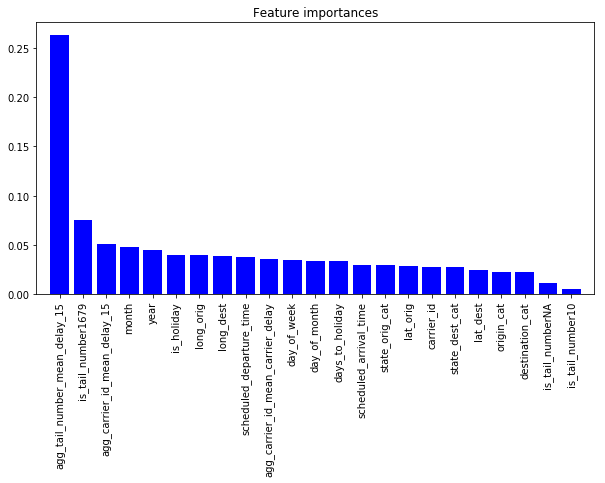

In [55]:
draw_feature_importances(model, sel_feats)